In [146]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import vaex
import shapefile as sh
from h3 import h3
from shapely.geometry import shape
import json
from shapely.geometry.polygon import Polygon, Point
import folium
from folium.plugins import HeatMap

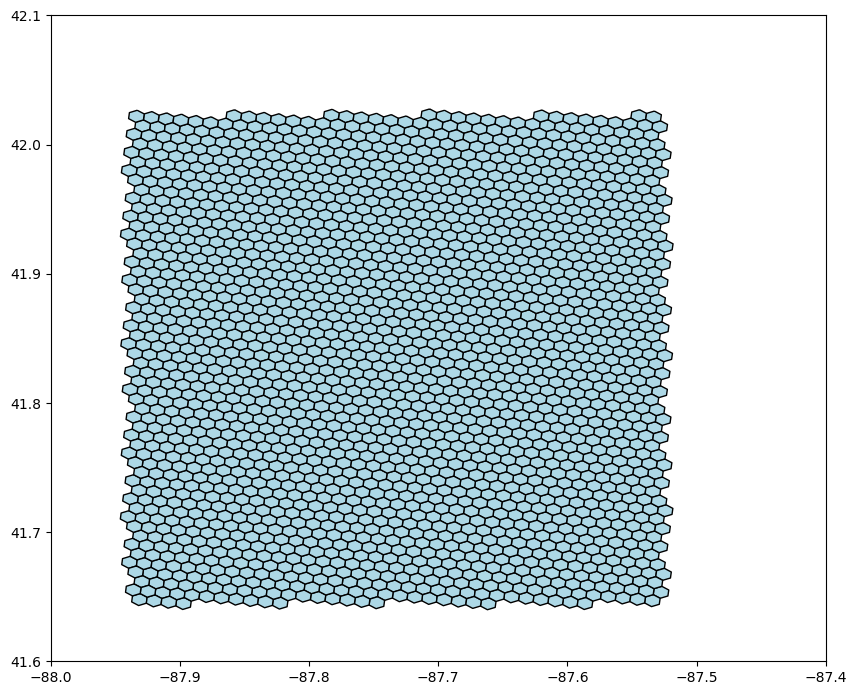

In [163]:
# Step 1: Define the boundary coordinates of Chicago
chicago_boundary = [
    [41.64454, -87.94013],
    [41.64454, -87.52399],
    [42.02303, -87.52399],
    [42.02303, -87.94013]
]

# Step 2: Define the desired resolution level
resolution = 8

# Step 3: Generate H3 hexagons covering the city
hexagons = h3.polyfill_polygon(chicago_boundary, resolution)

# Step 4: Remove hexagons outside the city
chicago_polygon = Polygon(chicago_boundary)
hexagons_within_city = [
    hexagon for hexagon in hexagons
    if chicago_polygon.contains(Point(h3.h3_to_geo(hexagon)))
]

# Step 5: Optional refinement (if needed)

# Convert hexagons to geopandas GeoDataFrame
hexagon_geometries = [
    Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True))
    for hexagon in hexagons_within_city
]
hexagon_gdf = gpd.GeoDataFrame(geometry=hexagon_geometries)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the hexagons
hexagon_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black')

# Plot the city boundary
chicago_gdf = gpd.GeoDataFrame(geometry=[chicago_polygon])
chicago_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=4)

# Set the axis limits
ax.set_xlim(-88, -87.4)
ax.set_ylim(41.6, 42.1)

# Display the plot
plt.show()




AttributeError: 'Polygon' object has no attribute 'plot'

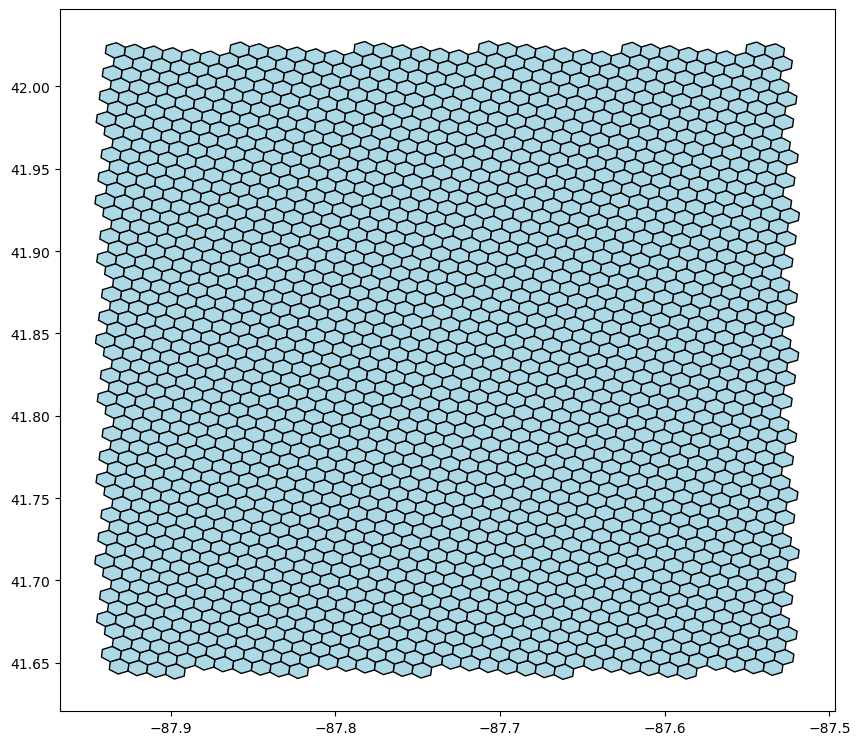

In [157]:
# Step 1: Define the boundary coordinates of Chicago
chicago_boundary = [
    [41.64454, -87.94013],
    [41.64454, -87.52399],
    [42.02303, -87.52399],
    [42.02303, -87.94013]
]

# Step 2: Define the desired resolution level
resolution = 8

# Step 3: Generate H3 hexagons covering the city
hexagons = h3.polyfill_polygon(chicago_boundary, resolution)

# Step 4: Remove hexagons outside the city
# Step 4: Remove hexagons outside the city
chicago_polygon = Polygon(chicago_boundary)
hexagons_within_city = [hexagon for hexagon in hexagons if chicago_polygon.contains(Point(h3.h3_to_geo(hexagon)))]

# Step 5: Optional refinement (if needed)

# Convert hexagons to geopandas GeoDataFrame
hexagon_geometries = [Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True)) for hexagon in hexagons_within_city]
hexagon_gdf = gpd.GeoDataFrame(geometry=hexagon_geometries)



# Plot the hexagons
fig, ax = plt.subplots(figsize=(10, 10))
hexagon_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black')

# Plot the city boundary
chicago_polygon.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Set the axis limits
ax.set_xlim(-88, -87.4)
ax.set_ylim(41.6, 42.1)

# Display the plot
plt.show()


In [130]:
import json
city_bounding_box = gpd.read_file('data/trips/Boundaries - City.geojson')
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

In [106]:
gdf = city_bounding_box

In [132]:
gdf = gpd.GeoSeries.to_crs(gdf, crs =4326)

In [133]:
city_map = folium.Map(location=[gdf.centroid.y, gdf.centroid.x], zoom_start=10)


C:\Users\phili\AppData\Local\Temp\ipykernel_29412\3333692757.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_map = folium.Map(location=[gdf.centroid.y, gdf.centroid.x], zoom_start=10)
c:\Users\phili\anaconda3\lib\site-packages\folium\utilities.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
c:\Users\phili\anaconda3\lib\site-packages\folium\utilities.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
c:\Users\phili\anaconda3\lib\site-packages\folium\utilities.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]

In [134]:
def create_hexagons(row):
    boundary = row['geometry']
    hex_coords = []
    for coords in boundary.exterior.coords:
        hex_coords.append([coords[1], coords[0]])
    hexagon = folium.vector_layers.Polygon(locations=hex_coords, color='blue', fill=True, fill_color='blue', fill_opacity=0.4)
    hexagon.add_to(city_map)


In [136]:
gdf.apply(create_hexagons)


TypeError: 'Polygon' object is not subscriptable

<Axes: >

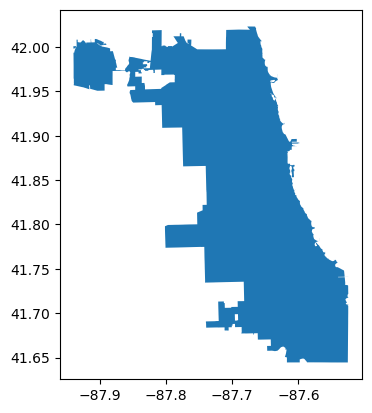

In [71]:
city_bounding_box.plot()

In [72]:
# Valid GeoJSON object
city_bounding_box_poly["geometry"]

{'type': 'MultiPolygon',
 'coordinates': [[[[-87.93514385942143, 42.00088911607326],
    [-87.9352110270025, 42.00081664143955],
    [-87.93529133950187, 42.00072700895027],
    [-87.93551196383594, 42.000480781935586],
    [-87.93574247939097, 42.00025812301311],
    [-87.93584505940073, 42.000159039381906],
    [-87.93590356821541, 42.00010497538239],
    [-87.93598608216818, 42.00001374987231],
    [-87.93632784066214, 41.99960326946243],
    [-87.9366154497264, 41.99923337944194],
    [-87.93677128867272, 41.999023248278675],
    [-87.9368759749499, 41.998881847153044],
    [-87.93693408810181, 41.99880335510703],
    [-87.93706164890665, 41.998612362462175],
    [-87.93707950926456, 41.998585741964575],
    [-87.93905445886887, 41.99826104013864],
    [-87.93982896518334, 41.99813745944146],
    [-87.93989441399762, 41.9981270162374],
    [-87.94002020835825, 41.99810694262792],
    [-87.94005007906628, 41.99896069051319],
    [-87.9400819857009, 41.9998725169338],
    [-87.940091

In [137]:
# Read GeoJSON file
with open('data/trips/Boundaries - City.geojson') as f:
    data = json.load(f)

# Iterate over features
for feature in data['features']:
    # Check if geometry is a MultiPolygon
    if feature['geometry']['type'] == 'MultiPolygon':
        multi_polygon = shape(feature['geometry'])

        # Convert MultiPolygon into individual polygons
        polygons = list(multi_polygon.geoms)

        # Update feature geometry with individual polygons
        feature['geometry'] = {
            'type': 'Polygon',
            'coordinates': [poly.exterior.coords[:] for poly in polygons]
        }

# Save modified GeoJSON file
with open('output.geojson', 'w') as f:
    json.dump(data, f)


In [138]:
city_bounding_box = gpd.read_file('./output.geojson')
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

In [139]:
gdf = city_bounding_box


In [140]:
gdf = gpd.GeoSeries.to_crs(gdf["geometry"], crs =4326)

In [141]:
city_map = folium.Map(location=[gdf.centroid.y, gdf.centroid.x], zoom_start=10)

C:\Users\phili\AppData\Local\Temp\ipykernel_29412\1159796782.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_map = folium.Map(location=[gdf.centroid.y, gdf.centroid.x], zoom_start=10)
c:\Users\phili\anaconda3\lib\site-packages\folium\utilities.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
c:\Users\phili\anaconda3\lib\site-packages\folium\utilities.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
c:\Users\phili\anaconda3\lib\site-packages\folium\utilities.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]

<Axes: >

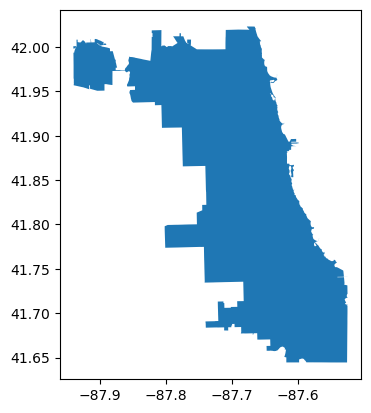

In [75]:
city_bounding_box.plot()

In [76]:
city_bounding_box_poly

{'id': '0',
 'type': 'Feature',
 'properties': {'name': 'CHICAGO',
  'objectid': '1',
  'shape_area': '6450276623.31',
  'shape_len': '845282.931362'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-87.93514385942143, 42.00088911607326],
    [-87.9352110270025, 42.00081664143955],
    [-87.93529133950187, 42.00072700895027],
    [-87.93551196383594, 42.000480781935586],
    [-87.93574247939097, 42.00025812301311],
    [-87.93584505940073, 42.000159039381906],
    [-87.93590356821541, 42.00010497538239],
    [-87.93598608216818, 42.00001374987231],
    [-87.93632784066214, 41.99960326946243],
    [-87.9366154497264, 41.99923337944194],
    [-87.93677128867272, 41.999023248278675],
    [-87.9368759749499, 41.998881847153044],
    [-87.93693408810181, 41.99880335510703],
    [-87.93706164890665, 41.998612362462175],
    [-87.93707950926456, 41.998585741964575],
    [-87.93905445886887, 41.99826104013864],
    [-87.93982896518334, 41.99813745944146],
    [-87.93989441399762, 41.9981

In [107]:
hexagons = []

In [77]:
city_bounding_box_poly['geometry']["coordinates"][0]

[[-87.93514385942143, 42.00088911607326],
 [-87.9352110270025, 42.00081664143955],
 [-87.93529133950187, 42.00072700895027],
 [-87.93551196383594, 42.000480781935586],
 [-87.93574247939097, 42.00025812301311],
 [-87.93584505940073, 42.000159039381906],
 [-87.93590356821541, 42.00010497538239],
 [-87.93598608216818, 42.00001374987231],
 [-87.93632784066214, 41.99960326946243],
 [-87.9366154497264, 41.99923337944194],
 [-87.93677128867272, 41.999023248278675],
 [-87.9368759749499, 41.998881847153044],
 [-87.93693408810181, 41.99880335510703],
 [-87.93706164890665, 41.998612362462175],
 [-87.93707950926456, 41.998585741964575],
 [-87.93905445886887, 41.99826104013864],
 [-87.93982896518334, 41.99813745944146],
 [-87.93989441399762, 41.9981270162374],
 [-87.94002020835825, 41.99810694262792],
 [-87.94005007906628, 41.99896069051319],
 [-87.9400819857009, 41.9998725169338],
 [-87.94009181181038, 42.000153432509286],
 [-87.94011408252348, 42.00078931826637],
 [-87.9399299489268, 42.000792164

In [96]:
# Step 2: Define the desired resolution level
resolution = 14

# Step 3: Generate H3 hexagons covering the city
hexagons = h3.polyfill(city_bounding_box_poly['geometry'], resolution)

# Step 4: Remove hexagons outside the city
# Step 4: Remove hexagons outside the city
chicago_polygon = Polygon(city_bounding_box_poly['geometry']["coordinates"][0])
hexagons_within_city = [hexagon for hexagon in hexagons if chicago_polygon.contains(Point(h3.h3_to_geo(hexagon)))]


['8ef175a43c8bc97',
 '8ef175a43caa017',
 '8ef175a43520a87',
 '8ef175a43c88cc7',
 '8ef175a43c88ccf',
 '8ef175a43ca5827',
 '8ef175a43ca166f',
 '8ef175a43caad5f',
 '8ef175a43c88447',
 '8ef175a43525d97',
 '8ef175a43c88457',
 '8ef175a43ca5167',
 '8ef175a43c8cc5f',
 '8ef175a43caa0af',
 '8ef175a43520baf',
 '8ef175a43523bb7',
 '8ef175a43c8bda7',
 '8ef175a43c8c44f',
 '8ef175a43c8b5a7',
 '8ef175a43c8cc0f',
 '8ef175a43caa707',
 '8ef175a435255b7',
 '8ef175a43ca516f',
 '8ef175a43ca164f',
 '8ef175a43cae0c7',
 '8ef175a43c8cd77',
 '8ef175a43c8b4d7',
 '8ef175a43caed6f',
 '8ef175a43ca5867',
 '8ef175a43ca5337',
 '8ef175a43c8cc1f',
 '8ef175a43cae8f7',
 '8ef175a43ca12a7',
 '8ef175a43caad77',
 '8ef175a43c8c7b7',
 '8ef175a43caa6c7',
 '8ef175a43c8ab5f',
 '8ef175a43ca1147',
 '8ef175a43c8c46f',
 '8ef175a43c8cd5f',
 '8ef175a43524377',
 '8ef175a43c8a26f',
 '8ef175a43cae107',
 '8ef175a43caa997',
 '8ef175a43ca521f',
 '8ef175a43524aef',
 '8ef175a43ca590f',
 '8ef175a43ca53b7',
 '8ef175a43c8aa57',
 '8ef175a43c8c0b7',


In [142]:
hexagon = folium.vector_layers.Polygon(locations=city_bounding_box_poly['geometry']["coordinates"][0], color='blue', fill=True, fill_color='blue', fill_opacity=0.4)
hexagon.add_to(city_map)

In [129]:
gdf.apply(create_hexagons)


TypeError: 'Polygon' object is not subscriptable

In [88]:
# Convert hexagons to geopandas GeoDataFrame
hexagon_geometries = [Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True)) for hexagon in hexagons]
hexagon_gdf = gpd.GeoDataFrame(geometry=hexagon_geometries)

GeometryTypeError: Unknown geometry type: 'featurecollection'

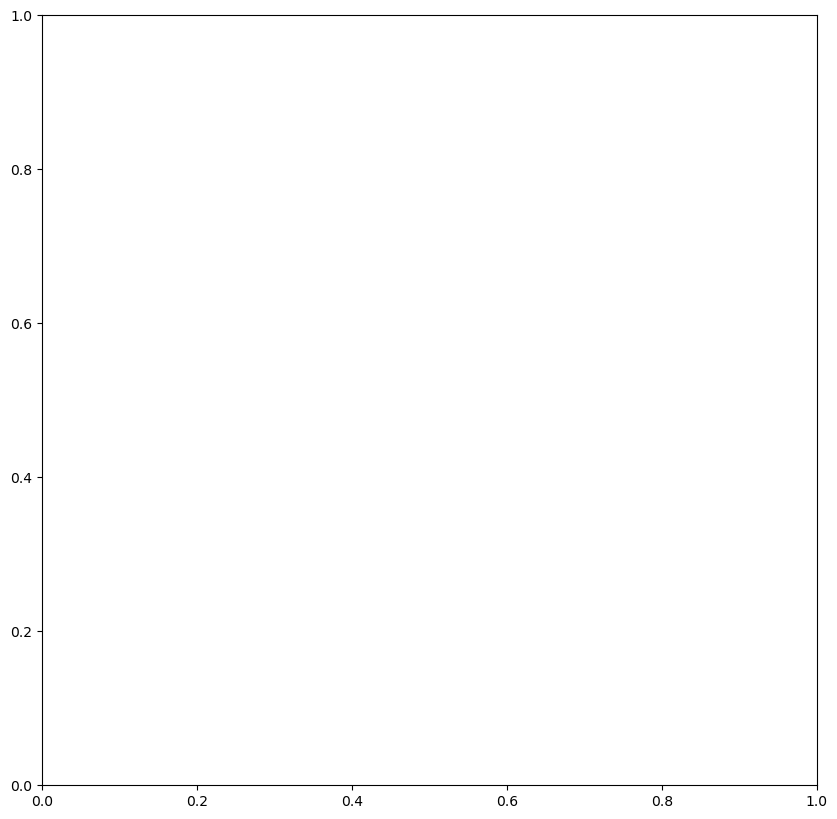

In [95]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the hexagons
# hexagon_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black')

# Plot the city boundary
chicago_gdf = gpd.GeoDataFrame(geometry=[city_bounding_box])
chicago_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Set the axis limits
ax.set_xlim(-87.98, -87.90)
ax.set_ylim(41.99, 42.01)

# Display the plot
plt.show()

In [108]:
polygon_h3 = h3.polyfill(city_bounding_box_poly['geometry'], res=13)
hexagons.extend(polygon_h3)

In [109]:
hexagons

['8df175a43ca193f',
 '8df175a43ca53bf',
 '8df175a43cae6ff',
 '8df175a43c8843f',
 '8df175a43caa6ff',
 '8df175a43caa73f',
 '8df175a43ca583f',
 '8df175a43c8ab7f',
 '8df175a43ca52bf',
 '8df175a43cae8bf',
 '8df175a43cae67f',
 '8df175a435232bf',
 '8df175a43c8c57f',
 '8df175a43c8bcbf',
 '8df175a43ca507f',
 '8df175a43ca117f',
 '8df175a43ca533f',
 '8df175a43c8cd7f',
 '8df175a43cae73f',
 '8df175a43ca103f',
 '8df175a43c8cc3f',
 '8df175a43ca587f',
 '8df175a43c8847f',
 '8df175a43ca13bf',
 '8df175a43c887bf',
 '8df175a43524aff',
 '8df175a43ca10ff',
 '8df175a43c8cc7f',
 '8df175a435255bf',
 '8df175a43ca12bf',
 '8df175a43ca107f',
 '8df175a43c8c7bf',
 '8df175a43c8b43f',
 '8df175a4352437f',
 '8df175a4350593f',
 '8df175a4352023f',
 '8df175a43ca167f',
 '8df175a43cae0ff',
 '8df175a43c8ccff',
 '8df175a43ca523f',
 '8df175a43cae63f',
 '8df175a43cae13f',
 '8df175a43caa63f',
 '8df175a43c8853f',
 '8df175a43524b3f',
 '8df175a4352033f',
 '8df175a43ca597f',
 '8df175a43c8b4bf',
 '8df175a43ca183f',
 '8df175a43c8c1bf',


In [111]:
from shapely.geometry import Polygon

hexagons_vertices = [h3.h3_to_geo_boundary(h) for h in hexagons]
hexagons_flat = [coord for vertices in hexagons_vertices for coord in vertices]
hexagons_gdf = gpd.GeoDataFrame(geometry=[Polygon(hexagons_flat)], crs='EPSG:4326')



<Axes: >

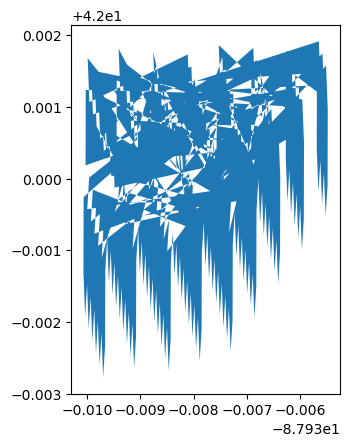

In [112]:
hexagons_gdf.plot()


In [53]:
# Computing hexagons for a given polygon
H3_HEXAGON_RESOLUTION = 11
polygon_obj = city_bounding_box_poly['geometry'] # your geo json object
hexagons = h3.polyfill(polygon_obj, res = H3_HEXAGON_RESOLUTION, geo_json_conformant = True)


In [39]:
# Returns only the index of each hexagon, not the geometries
hexagons

{'8b2759342040fff',
 '8b2759342041fff',
 '8b2759342042fff',
 '8b2759342043fff',
 '8b2759342044fff',
 '8b2759342045fff',
 '8b2759342046fff',
 '8b275934204cfff',
 '8b275934204efff',
 '8b275934205cfff',
 '8b275934205dfff',
 '8b2759342060fff',
 '8b2759342061fff',
 '8b2759342062fff',
 '8b2759342063fff',
 '8b2759342064fff',
 '8b2759342065fff',
 '8b2759342066fff',
 '8b2759342068fff',
 '8b2759342069fff',
 '8b275934206afff',
 '8b275934206bfff',
 '8b275934206cfff',
 '8b275934206dfff',
 '8b275934206efff',
 '8b2759342070fff',
 '8b2759342071fff',
 '8b2759342073fff',
 '8b2759342074fff',
 '8b2759342075fff',
 '8b2759342149fff',
 '8b275934214bfff',
 '8b275934215bfff',
 '8b2759342a90fff',
 '8b2759342a92fff',
 '8b2759342a93fff',
 '8b2759342a94fff',
 '8b2759342a95fff',
 '8b2759342a96fff',
 '8b2759342ab2fff',
 '8b2759342ab3fff'}

In [40]:
# Convert H3 Indexes to Geometry Objects

# Create geo data frame
df = gpd.GeoDataFrame(list(hexagons), columns=['h3_hex_id'])

df['geometry'] = df[(df['h3_hex_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)

C:\Users\phili\AppData\Local\Temp\ipykernel_4320\2798711449.py:6: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df['geometry'] = df[(df['h3_hex_id'].notna())].apply(lambda row: shape({"type": "Polygon",


<Axes: >

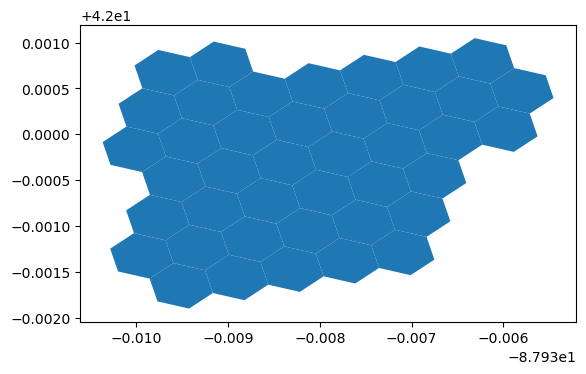

In [41]:
df.plot()

In [42]:
df_vaex = vaex.open("data/trips/trips.hdf5")

<Axes: >

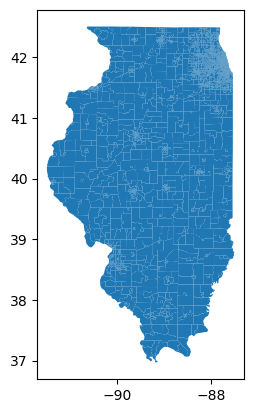

In [3]:
shape = gpd.read_file('data/poi/cb_2022_17_tract_500k.shp')
shape.plot()

In [47]:
# Load the census tract data as a pandas DataFrame
data_path = 'data/trips/trips.hdf5'
df_vaex = vaex.open(data_path)


In [5]:
# Load the census tract shapefile for Chicago
shapefile_path = 'data/poi/cb_2022_17_tract_500k.shp'
chicago_map = gpd.read_file(shapefile_path)


In [20]:
print(chicago_map.info)

<bound method DataFrame.info of      STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME   
0         17      143  004600  1400000US17143004600  17143004600       46  \
1         17      143  000300  1400000US17143000300  17143000300        3   
2         17      073  030600  1400000US17073030600  17073030600      306   
3         17      073  030900  1400000US17073030900  17073030900      309   
4         17      107  953200  1400000US17107953200  17107953200     9532   
...      ...      ...     ...                   ...          ...      ...   
3258      17      201  003706  1400000US17201003706  17201003706    37.06   
3259      17      089  851301  1400000US17089851301  17089851301  8513.01   
3260      17      019  005402  1400000US17019005402  17019005402    54.02   
3261      17      031  410600  1400000US17031410600  17031410600     4106   
3262      17      043  846603  1400000US17043846603  17043846603  8466.03   

                  NAMELSAD STUSPS        NA

In [6]:

# Convert the census tract column to string data type
df_vaex['Pickup Census Tract'] = df_vaex['Pickup Census Tract'].astype(str)

In [27]:
df_pandas = df_vaex.sample(10000).to_pandas_df()

In [28]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Trip ID                     10000 non-null  object 
 1   Taxi ID                     10000 non-null  object 
 2   Trip Start Timestamp        10000 non-null  object 
 3   Trip End Timestamp          9998 non-null   object 
 4   Trip Seconds                9957 non-null   float64
 5   Trip Miles                  10000 non-null  float64
 6   Pickup Census Tract         10000 non-null  object 
 7   Dropoff Census Tract        6662 non-null   float64
 8   Pickup Community Area       8765 non-null   float64
 9   Dropoff Community Area      8577 non-null   float64
 10  Fare                        10000 non-null  float64
 11  Tips                        10000 non-null  float64
 12  Tolls                       8312 non-null   float64
 13  Extras                      1000

In [34]:
# Join the census tract data with the shapefile based on the census tract column
merged = chicago_map.merge(df_pandas, left_on='TRACTCE', right_on='Pickup Census Tract')

In [35]:
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 0 entries
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   STATEFP                     0 non-null      object  
 1   COUNTYFP                    0 non-null      object  
 2   TRACTCE                     0 non-null      object  
 3   AFFGEOID                    0 non-null      object  
 4   GEOID                       0 non-null      object  
 5   NAME                        0 non-null      object  
 6   NAMELSAD                    0 non-null      object  
 7   STUSPS                      0 non-null      object  
 8   NAMELSADCO                  0 non-null      object  
 9   STATE_NAME                  0 non-null      object  
 10  LSAD                        0 non-null      object  
 11  ALAND                       0 non-null      int64   
 12  AWATER                      0 non-null      int64   
 13  geometry                